Библиотека [Transformers](https://huggingface.co/docs/transformers/index) от Hugging Face позволяет скачивать предобученные модели и использовать их как начальный блок для подсчета контекстных векторов слов. Поверх этого блока добавляются другие слои, их архитектура зависит от задачи. Веса трансформерных моделей предобучены, но мы проводим дообучение (fine-tuning) на целевой задаче.

Сегодня мы рассмотрим, как можно осуществлять дообучение модели BERT для классификации предложений, а именно для анализа тональности отзывов на приложения в Google Play.

## Загрузка данных

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 33.7 MB/s eta 0:00:00


Загрузим данные, которые мы будем использовать для обучения и тестирования модели, — отзывы на приложения в Google Play.


In [ ]:
!wget https://raw.githubusercontent.com/Xeanst/NN_in_compling/main/09_bert/reviews.csv

--2023-05-19 09:11:51--  https://raw.githubusercontent.com/Xeanst/NN_in_compling/main/09_bert/reviews.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7170328 (6.8M) [text/plain]
Saving to: ‘reviews.csv’

reviews.csv         100%[===================>]   6.84M  --.-KB/s    in 0.06s   

2023-05-19 09:11:52 (113 MB/s) - ‘reviews.csv’ saved [7170328/7170328]



In [ ]:
import pandas as pd

df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [ ]:
df.shape

(15746, 11)

Нас будут интересовать столбец "content", содержащий отзыв, и столбец "score" с оценкой (классом).

Посмотрим на распределение классов в выборке

3    0.320208
5    0.184174
4    0.176299
1    0.162962
2    0.156357
Name: score, dtype: float64


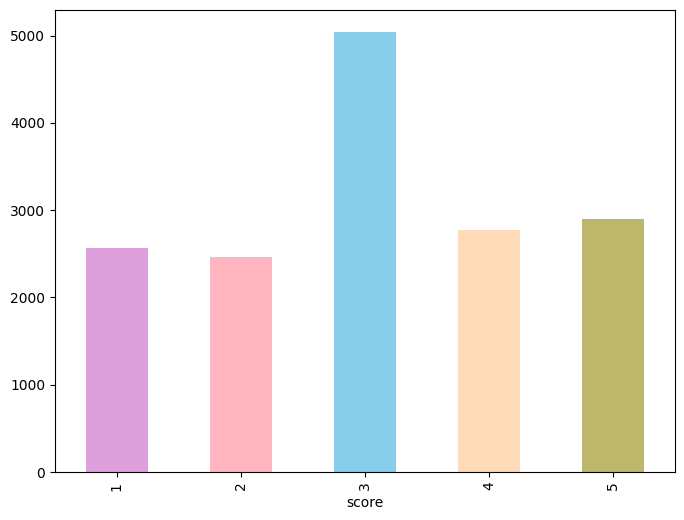

In [ ]:
import matplotlib.pyplot as plt

print(df['score'].value_counts(normalize=True))

fig = plt.figure(figsize=(8,6))
df.groupby('score').content.count().plot.bar(ylim=0, color=['plum', 'lightpink', 'skyblue', 'peachpuff', 'darkkhaki'])
plt.show()

Можем заметить, что данные несбалансированы: отзывов с оценкой "3" больше всего, с остальными оценками значительно меньше.

Объединим классы "1" и "2", а также классы "4" и "5". Теперь отзывы разделены на 3 класса: негативные (1,2), нейтральные (3) и позитивные (4,5).

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

В таком виде классы почти сбалансированы.

2    0.360473
1    0.320208
0    0.319319
Name: sentiment, dtype: float64


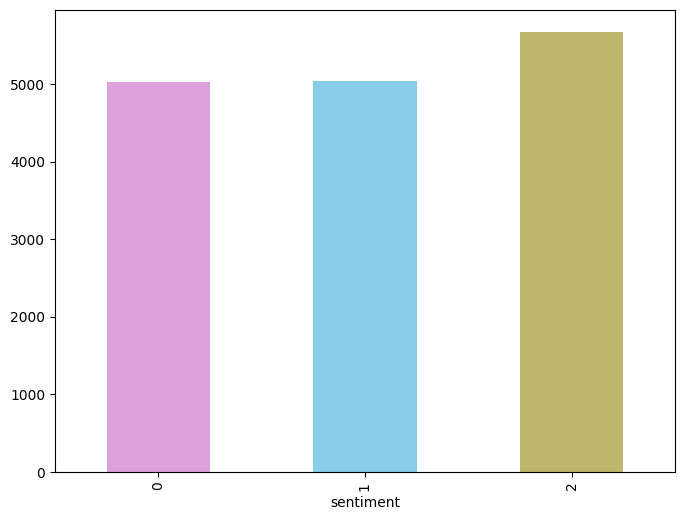

In [ ]:
print(df['sentiment'].value_counts(normalize=True))

fig = plt.figure(figsize=(8,6))
df.groupby('sentiment').content.count().plot.bar(ylim=0, color=['plum', 'skyblue', 'darkkhaki'])
plt.show()

## Предобработка данных

При работе с моделью BERT предобработка в традиционном смысле (удаление стоп-слов, знаков препинания) не требуется.

Нужна предобработка другого рода:
* добавление спецтокенов для разделения предложений [SEP] и классификации [CLS]
* приведение всех предложений к одинаковой длине (паддинг)
* создание маски внимания (attention mask) — списка  из 0 и 1, где 0 соответствует вспомогательным токенам (padding), а 1 — настоящим.

Нам не нужно самим добавлять спецсимволы и составлять словарь соответствия токенов и индексов. Это сделает токенизатор, соотвествующий выбранной модели. Сегодня мы будем использовать модель 'bert-base-cased'.

In [ ]:
PRE_TRAINED_MODEL_NAME = 'google-bert/bert-base-cased'

Для каждой архитектуры существуют свои классы для токенизаторов и моделей:

- [BERT](https://huggingface.co/docs/transformers/model_doc/bert): [BertTokenizer](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertTokenizer) и [BertModel](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel),
- [RoBERTa](https://huggingface.co/docs/transformers/model_doc/roberta): [RobertaTokenizer](https://huggingface.co/docs/transformers/model_doc/roberta#transformers.RobertaTokenizer) и [RobertaModel](https://huggingface.co/docs/transformers/model_doc/roberta#transformers.RobertaModel).

Однако также можно использовать [автоматические классы ](https://huggingface.co/docs/transformers/model_doc/auto): [AutoTokenizer](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer) и [AutoModel](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModel). Они автоматически создают класс нужной архитектуры (BERT, RoBERTa и т.д.). Это делает очень простой замену модели — достаточно просто поменять идентификатор.

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Вспомним, как работает модель токенизации для BERT.

📌 Токенизируйте текст `sample_txt` и переведите токены `tokens` в индексы `token_ids`.

In [ ]:
sample_txt = 'He started a new book, it was quite readable'

tokens = tokenizer.tokenize(sample_txt) # Место для вашего кода
token_ids = tokenizer.convert_tokens_to_ids(tokens) # Место для вашего кода

print(f'Предложение: {sample_txt}')
print(f'Токены: {tokens}')
print(f'Индексы токенов: {token_ids}')

Предложение: He started a new book, it was quite readable
Токены: ['He', 'started', 'a', 'new', 'book', ',', 'it', 'was', 'quite', 'read', '##able']
Индексы токенов: [1124, 1408, 170, 1207, 1520, 117, 1122, 1108, 2385, 2373, 1895]


### Специальные токены

Токенизатор уже содержит индексы для спецсимволов:
- [SEP] — метка конца предложения
- [CLS] — токен для классификации предложения
- [PAD] — токен для выравнивания длин последовательностей

In [ ]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)

[SEP] 102
[CLS] 101
[PAD] 0


Вся предобработка может быть сделана с помощью метода `encode_plus`. Он возвращает словарь с ключами `input_ids` и `attention_mask`.

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt, # преобразуемый текст
  max_length=32, # максимальная длина
  add_special_tokens=True, # добавить спецтокены [CLS] и [SEP]
  return_token_type_ids=False, # вернуть номер предложения
  padding='max_length', # паддинг по установленной максимальной длине
  return_attention_mask=True, # создать маску для механизма внимания
  return_tensors='pt', # вернуть тензор PyTorch
  truncation=True # обрезать предложения длинее max_length
)
encoding

{'input_ids': tensor([[ 101, 1124, 1408,  170, 1207, 1520,  117, 1122, 1108, 2385, 2373, 1895,
          102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}

📌 Определите длину списка индексов и списка масок. Преобразуйте список индексов обратно в последовательность токенов.

In [ ]:
# Место для вашего кода
print(len(encoding['input_ids'][0]))
print(len(encoding['attention_mask'][0]))
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

32
32


['[CLS]',
 'He',
 'started',
 'a',
 'new',
 'book',
 ',',
 'it',
 'was',
 'quite',
 'read',
 '##able',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Унификация длины предложений

Проанализируем, какая длина отзывов встречается в данных чаще. Отберем отзывы длины менее 512 токенов, поскольку это максимальная длина последовательности для модели BERT.

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


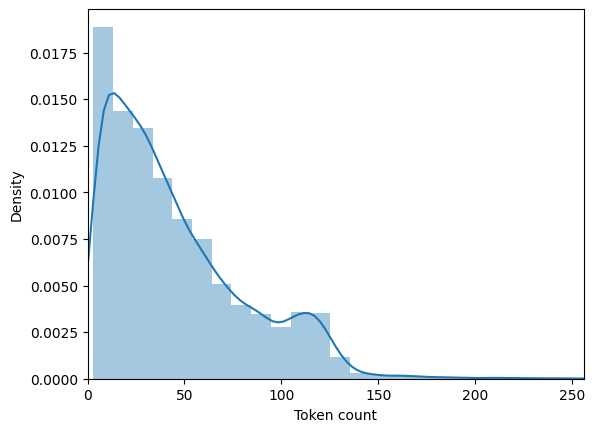

In [ ]:
token_lens = []
for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Установим максимальную длину последовательности равной 150.

In [ ]:
MAX_LEN = 150

### Создание датасета

Теперь создадим датасет PyTorch, который понадобится для обучения и тестирования модели.
- В методе `__init__` задаем тексты отзывов (`self.reviews`), метки классов (`self.targets`), токенизатор (`self.tokenizer`) и максимальную длину последовательности (`self.max_len`).
- В методе `__len__` определяем размер датасета.
- В методе `__getitem__` сопоставляем тексты отзывов и метки классов по индексу (`item`). Метод возвращает словарь: текст отзыва, индексы токенов, маску внимания, метку класса.

📌 Добавьте предобработку отзыва `review`: преобразуйте его в словарь `encoding` с помощью метода `encode_plus`, добавьте спецтокены, установите максимальную длину для паддинга, не возвращайте номер предложения, задайте паддинг по максимальной установленной длине, создайте маску для механизма внимания, установите формат списка индексов как тензор pytorch, установите усечение для предложений больше максимальной длины.

In [ ]:
from torch.utils.data import Dataset

class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    # Место для вашего кода
    encoding = tokenizer.encode_plus(
      review,
      max_length=self.max_len,
      add_special_tokens=True,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

Разделим данные на обучающую, валидационную и тестовую выборки. 90% всех данных отберем для обучения, оставшиеся 10% поделим пополам для валидации и тестирования.

In [ ]:
import torch
from sklearn.model_selection import train_test_split

RANDOM_SEED = 1
torch.manual_seed(RANDOM_SEED)
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
print(f'Обучающая выборка: {df_train.shape}')
print(f'Валидационная выборка: {df_val.shape}')
print(f'Тестовая выборка: { df_test.shape}')

Обучающая выборка: (14171, 12)
Валидационная выборка: (787, 12)
Тестовая выборка: (788, 12)


Будем использовать графический процессор для вычислений.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Создадим итераторы по данным:
- `train_data_loader` — данные для дообучения модели;
- `val_data_loader` — данные для валидации модели при обучении;
- `test_data_loader` — данные для тестирования модели.

In [ ]:
from torch.utils.data import DataLoader

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=1
  )

BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Посмотрим на пример одного батча из итератора `train_data_loader`.



In [ ]:
data = next(iter(train_data_loader))
print(f'Батч:\n{data.keys()}\n')
print(f"Предложения в батче:\n{data['review_text']}\n")
print(f"Индексы токенов:\n{data['input_ids'].shape}\nbatch size x max len\n")
print(f"Маски внимания:\n{data['attention_mask'].shape}\nbatch size x max len\n")
print(f"Метки классов:\n{data['targets']}")
print(data['targets'].shape)

Батч:
dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

Предложения в батче:
["I had a problem with upgrading to Premium. They were quick with their response and fixed the problem right away. It's a good app for those familiar with the Franklin Covey system, and syncs well across devices.", 'Same issue as Don Smith who wrote a review on 10/10/19. Will consider this app but the lack of slide visuals and character visuals makes the app in-op. Current phone is the Google pixel 4xl......perhaps I misspoke in regards to the reply. My issue is not with the visuals but the lack of visuals. Everything is blank for me so literally can not see half of the content.', "I actually really love this app. I used it to create some serious personal progress. I purchased the full app but when I bought a new phone, it wouldn't let me sign out of my old device and into my new device. I emailed support about it...crickets. Never heard from them. If they can put together a decent support 

## Загрузка и создание модели

### Загрузка предобученной модели

In [ ]:
from transformers import AutoModel
bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

Попробуем использовать эту модель. Применим её к токенизированному предложению. Модель принимает индексы токенов и маску внимания.

В переменную `hidden_states` записаны скрытые состояние слоя эмбеддингов и всех слоев энкодера (векторы каждого токена в предложении), в переменную `last_hidden_state` — скрытые состояния последнего слоя энкодера модели. Переменная `pooled_output` содержит выход линейного слоя модели — контекстный вектор для токена [CLS].

In [ ]:
print(f"Токены:\n{tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])}")
print(f"Индексы токенов:\n{encoding['input_ids'][0]}")
print(f"Маска внимания:\n{encoding['attention_mask']}")

last_hidden_state, pooled_output, hidden_states = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask'],
  output_hidden_states=True,
  return_dict=False)

print(f'\nВсего скрытых состояний: {len(hidden_states)}')
print(f'Размер скрытых состояний последнего слоя: {last_hidden_state.shape}')
print(f'Размер выхода линейного слоя: {pooled_output.shape}')

Токены:
['[CLS]', 'He', 'started', 'a', 'new', 'book', ',', 'it', 'was', 'quite', 'read', '##able', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Индексы токенов:
tensor([ 101, 1124, 1408,  170, 1207, 1520,  117, 1122, 1108, 2385, 2373, 1895,
         102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
Маска внимания:
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

Всего скрытых состояний: 13
Размер скрытых состояний последнего слоя: torch.Size([1, 32, 768])
Размер выхода линейного слоя: torch.Size([1, 768])


### Анализ контекстных векторов

Посмотрим на векторы модели BERT для некоторых слов в предложениях.

In [ ]:
text1 = df.loc[16]['content']
text2 = df.loc[338]['content']
print(text1)
print(text2)

Couldn't even set up one single recurring reminder without being required to pay monthly subscription. Get your greedy hand off it dev. It's only only a reminder app not a useful service.
Well designed and all however alot of the crutial features are locked behind the premium which u need to pay for


Посчитаем косинусное расстояние для векторов слов "subscription" и "premium", а также "subscription" и "well".

Осуществим предобработку первого предложения, пропустим его через модель и запишем вектор слова "subscription".

In [ ]:
encoding = tokenizer.encode_plus(
  text1,
  max_length=30,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)
print(f"Токенизированное предложение: {tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])}")

position1 = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]).index('subscription')
print(f'Позиция слова "subscription": {position1}')

last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask'],
  return_dict=False)
emb1 = last_hidden_state[0, position1, :] # Место для вашего кода
print(f'Размер вектора "subscription": {emb1.shape}')

Токенизированное предложение: ['[CLS]', 'Couldn', "'", 't', 'even', 'set', 'up', 'one', 'single', 'recurring', 'reminder', 'without', 'being', 'required', 'to', 'pay', 'monthly', 'subscription', '.', 'Get', 'your', 'greedy', 'hand', 'off', 'it', 'de', '##v', '.', 'It', '[SEP]']
Позиция слова "subscription": 17
Размер вектора "subscription": torch.Size([768])


Осуществим предобработку второго предложения, пропустим его через модель и запишем векторы слова "premium" и "well".

In [ ]:
encoding2 = tokenizer.encode_plus(
  text2,
  max_length=30,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)

print(f"Токенизированное предложение: {tokenizer.convert_ids_to_tokens(encoding2['input_ids'][0])}")
position2=tokenizer.convert_ids_to_tokens(encoding2['input_ids'][0]).index('premium')
print(f'Позиция слова "premium": {position2}')
position3=tokenizer.convert_ids_to_tokens(encoding2['input_ids'][0]).index('Well')
print(f'Позиция слова "well": {position3}')

last_hidden_state2, pooled_output2 = bert_model(
  input_ids=encoding2['input_ids'],
  attention_mask=encoding2['attention_mask'],
  return_dict=False)

emb2 = last_hidden_state2[0, position2, :] # Место для вашего кода
emb3 = last_hidden_state2[0, position3, :] # Место для вашего кода
print(f'Размер вектора "premium": {emb2.shape}')
print(f'Размер вектора "well": {emb3.shape}')

Токенизированное предложение: ['[CLS]', 'Well', 'designed', 'and', 'all', 'however', 'al', '##ot', 'of', 'the', 'c', '##ru', '##tial', 'features', 'are', 'locked', 'behind', 'the', 'premium', 'which', 'u', 'need', 'to', 'pay', 'for', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Позиция слова "premium": 18
Позиция слова "well": 1
Размер вектора "premium": torch.Size([768])
Размер вектора "well": torch.Size([768])


Посчитаем косинусное расстояние.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

print(f'Косинусное расстояние между словами "subscription" и "premium": {cosine_similarity( [emb1.detach().cpu().numpy()], [emb2.detach().cpu().numpy()])[0][0]}')
print(f'Косинусное расстояние между словами "subscription" и "well": {cosine_similarity( [emb1.detach().cpu().numpy()], [emb3.detach().cpu().numpy()])[0][0]}')

Косинусное расстояние между словами "subscription" и "premium": 0.727958083152771
Косинусное расстояние между словами "subscription" и "well": 0.5046451091766357


### Создание модели для классификации

Создадим класс `SentimentClassifier` на основе модели BERT.


In [ ]:
from torch import nn

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super().__init__()
    self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
n_classes = len(set(df['sentiment']))
model = SentimentClassifier(n_classes)
model = model.to(device)
model

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

Перенесем на видеокарту один из батчей для примера и применим модель к данным.

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(f'Индексы токенов:\n{input_ids.shape}\nbatch size x seq length')
print(f'Маска внимания:\n{attention_mask.shape}\nbatch size x seq length')

output = model(input_ids, attention_mask)
print(f'\nВыход модели:\n{output}')
print(f'Размер:\n{output.shape}\nbatch size x num classes')

Индексы токенов:
torch.Size([16, 150])
batch size x seq length
Маска внимания:
torch.Size([16, 150])
batch size x seq length

Выход модели:
tensor([[ 0.0556, -0.2529, -0.1797],
        [ 0.0767, -0.5307, -0.2737],
        [ 0.6255, -0.6882, -0.3278],
        [ 0.2825, -0.5606, -0.6447],
        [ 0.8668, -0.4061, -0.3044],
        [ 0.3364, -0.5741, -0.4718],
        [ 0.5770,  0.0060, -0.2736],
        [ 0.7557,  0.1847, -0.6131],
        [-0.0998, -0.2308,  0.0432],
        [ 0.1501, -0.2210, -0.3643],
        [ 0.6239,  0.0186, -0.2030],
        [ 0.3271, -0.1744, -0.6153],
        [ 0.6837, -0.2493, -0.0957],
        [ 0.1586, -0.1233, -0.0780],
        [ 0.5800, -0.4294, -0.4224],
        [ 0.0993, -0.4058, -0.4467]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Размер:
torch.Size([16, 3])
batch size x num classes


## Обучение, валидация и тестирование модели

### Обучение и валидация

Для дообучения модели будем использовать оптимизатор [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) из библиотеки Transformers.

Авторы модели BERT рекомендуют использовать следующие параметры для дообучения модели:
- Размер батча: 16, 32
- Скорость обучения (с оптимизатором Adam): 5e-5, 3e-5, 2e-5
- Количество эпох: 2, 3, 4

Дообучение может происходить двумя способами:
- меняются веса на всех слоях (`requires_grad=True`);
- часть весов замораживается (`requires_grad=False`), для оставшихся слоев веса меняются (`requires_grad=True`).

По умолчанию для всех весов `requires_grad=True`. Чтобы заморозить веса, нужно установить параметр `requires_grad=False`. Заморозим веса для первых 5 слоев энкодера.

In [ ]:
print(f'До заморозки:\n {list(model.bert.encoder.layer[4].parameters())[0]}')

for layer_id in range(5):
  for param in list(model.bert.encoder.layer[layer_id].parameters()):
    param.requires_grad = False

print(f'\nПосле заморозки:\n {list(model.bert.encoder.layer[4].parameters())[0]}')

До заморозки:
 Parameter containing:
tensor([[-0.0364,  0.0123, -0.0401,  ..., -0.0093,  0.0494,  0.0578],
        [ 0.0379, -0.0344, -0.0024,  ..., -0.0349,  0.0399,  0.0477],
        [-0.0212, -0.1096, -0.0186,  ..., -0.0002,  0.0115,  0.1223],
        ...,
        [ 0.0358,  0.0549, -0.0339,  ..., -0.0911, -0.0032,  0.0353],
        [-0.0011, -0.0193, -0.0354,  ...,  0.0179,  0.0108,  0.0361],
        [-0.0437, -0.0433,  0.0228,  ..., -0.0385,  0.0228, -0.0481]],
       device='cuda:0', requires_grad=True)

После заморозки:
 Parameter containing:
tensor([[-0.0364,  0.0123, -0.0401,  ..., -0.0093,  0.0494,  0.0578],
        [ 0.0379, -0.0344, -0.0024,  ..., -0.0349,  0.0399,  0.0477],
        [-0.0212, -0.1096, -0.0186,  ..., -0.0002,  0.0115,  0.1223],
        ...,
        [ 0.0358,  0.0549, -0.0339,  ..., -0.0911, -0.0032,  0.0353],
        [-0.0011, -0.0193, -0.0354,  ...,  0.0179,  0.0108,  0.0361],
        [-0.0437, -0.0433,  0.0228,  ..., -0.0385,  0.0228, -0.0481]],
       dev

Зададим количество эпох и скорость обучения. Будем использовать планировщик (`scheduler`), он регулирует скорость обучения: первые несколько шагов (`num_warmup_steps`) она может увеличиваться, а потом уменьшается. Также определим функцию потерь.

In [ ]:
EPOCHS = 2

from transformers import AdamW, get_linear_schedule_with_warmup
# Обучение всех слоев
#optimizer = AdamW(model.parameters(), lr=2e-5) # обучение всех слоев
# Для обучения только незамороженных слоев нужно установить фильтр
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Реализуем функцию для одной эпохи обучения.

In [ ]:
import numpy as np

def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train() # переводим модель в состояние обучения

  losses = [] # значения функцим потерь
  correct_predictions = 0 # значения accuracy

  for d in data_loader: # итерация по батчам
    input_ids = d["input_ids"].to(device) # индексы токенов
    attention_mask = d["attention_mask"].to(device) # маски внимания
    targets = d["targets"].to(device) # метки классов

    outputs = model( # применяем модель
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    preds = torch.argmax(outputs, dim=1) # позиция максимального значения
    loss = loss_fn(outputs, targets) # подсчет функции потерь

    correct_predictions += torch.sum(preds == targets) # количество совпадений
    losses.append(loss.item())

    loss.backward() # подсчет градиента
    optimizer.step() # обновление весов
    scheduler.step() # изменение скорости обучения
    optimizer.zero_grad() # обнуление градиентов

  return correct_predictions / n_examples, np.mean(losses) # accuracy, среднее значение ошибки

Также реализуем функцию для валидации.

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval() # переводим модель в состояние валидации

  losses = [] # значения функцим потерь
  correct_predictions = 0 # значения accuracy

  with torch.no_grad(): # грандиент не считается
    for d in data_loader: # итерация по батчам
      input_ids = d["input_ids"].to(device) # индексы токенов
      attention_mask = d["attention_mask"].to(device) # маски внимания
      targets = d["targets"].to(device) # метки классов

      outputs = model( # применяем модель
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      preds = torch.argmax(outputs, dim=1) # позиция максимального значения
      loss = loss_fn(outputs, targets) # подсчет функции потерь

      correct_predictions += torch.sum(preds == targets) # количество совпадений
      losses.append(loss.item())

  return correct_predictions / n_examples, np.mean(losses) # accuracy, среднее значение ошибки

Используя эти две функции, реализуем процедуру дообучения модели.

In [ ]:
%%time

# будем записывать значение ошибки и accuracy при обучении и валидации
from collections import defaultdict
history = defaultdict(list)

for epoch in range(EPOCHS): # итерация по эпохам

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch( # обучение
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model( # валидация
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

Epoch 1/2
----------
Train loss 0.7498174100172439 accuracy 0.6533060669898987
Val loss 0.5932408750057221 accuracy 0.756035566329956

Epoch 2/2
----------
Train loss 0.5386632701411473 accuracy 0.7729165554046631
Val loss 0.53375741481781 accuracy 0.7649300694465637

CPU times: user 9min 10s, sys: 1min 54s, total: 11min 4s
Wall time: 11min 14s


Можем сравнить точность на обучающей и валидационной выборке.

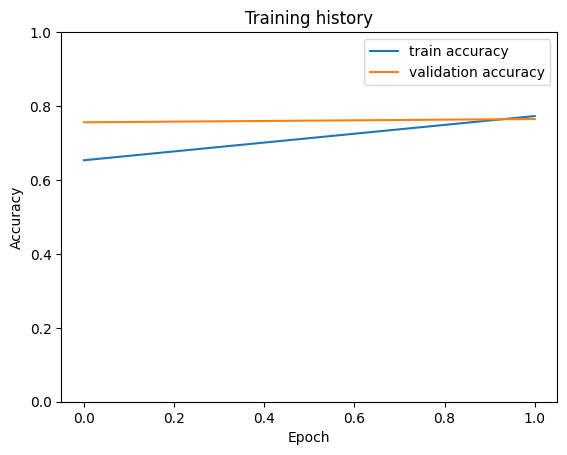

In [ ]:
history['train_acc'] = [score.to('cpu') for score in  history['train_acc']]
history['val_acc'] = [score.to('cpu') for score in  history['val_acc']]

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Тестирование

Подсчитаем точность (accuracy) модели на тестовой выборке.

In [ ]:
test_acc, _ = eval_model( # тестирование
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.7677664756774902

Accuracy на тестовых данных и на валидационной выборке дают близкие значения. Из этого можно сделать вывод, что получившаяся модель обладает хорошей обобщающей способностью.

Также можем отобразить матрицу ошибок для тестовых данных.

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  predictions = [] # предсказанные метки
  real_values = [] # правильные метки

  with torch.no_grad(): # грандиент не считается
    for d in data_loader: # итерация по батчам
      input_ids = d["input_ids"].to(device) # индексы токенов
      attention_mask = d["attention_mask"].to(device) # маски внимания
      targets = d["targets"].to(device) # метки классов

      outputs = model( # применяем модель
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      preds = torch.argmax(outputs, dim=1) # позиция максимального значения

      predictions.extend(preds)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()

  return predictions, real_values

y_pred, y_test = get_predictions(model, test_data_loader)

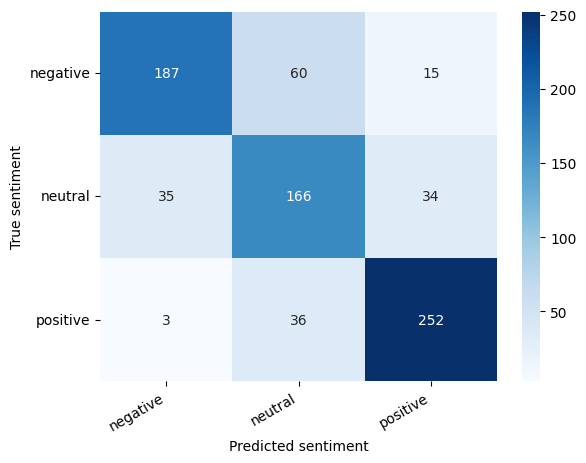

In [ ]:
from sklearn.metrics import confusion_matrix
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

class_names = ['negative', 'neutral', 'positive']
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

📌 Какие отзывы модели сложнее всего классифицировать?

### Предсказание на произвольных текстах

Теперь нам осталось научиться использовать нашу модель для предсказания тональности любого текста.

📌 Придумайте свой отзыв и проверьте работу модели.

In [ ]:
review_text = "I love completing my todos! Best app ever!!!" # Место для вашего отзыва

Для использования нашей модели нам следует токенизировать текст соответствующим образом.

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)

Теперь получим предсказания нашей модели.

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
prediction = torch.argmax(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive
